# Complex Bayesian optimization

This notebook is only here to illustrates how Bayesian optimization may be used on more complex use cases with a true behavior more difficult to approximate (see `true_function`).

In [1]:
import numpy as np
np.random.seed(42)

from skopt import Optimizer

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
search_space = {
    'param_1': (0.0, 25.0),
    'param_2': (0.0, 25.0)
}

In [3]:
x_graph = np.arange(search_space['param_1'][0], search_space['param_1'][1], 0.5)
y_graph = np.arange(search_space['param_2'][0], search_space['param_2'][1], 0.5)

X, Y = np.meshgrid(x_graph, y_graph)

## Mocking the behavior of the database

In [4]:
def true_function(x):
    y = np.cos(x[0] / 5) * np.sin(x[1] / 5) + x[1] / 25
    return y

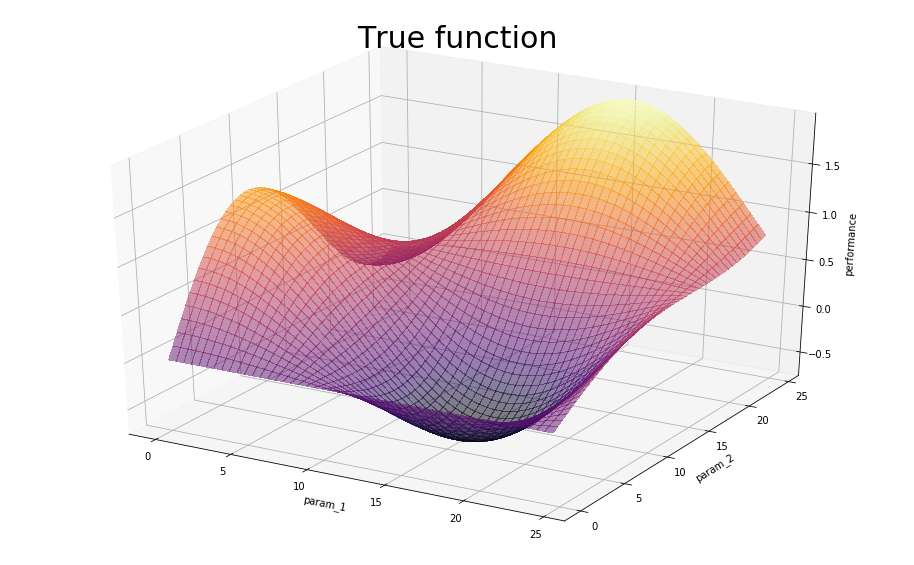

In [5]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('True function', fontdict={'size':30})

z_graph = np.array([true_function([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = z_graph.reshape(X.shape)

ax.set_xlabel('param_1')
ax.set_ylabel('param_2')
ax.set_zlabel('performance')
ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.5)

## Running the optimization

In [6]:
opt = Optimizer([search_space['param_1'], search_space['param_2']], 
                "GP", 
                n_initial_points=5)

In [7]:
for _ in range(5):
    # What value should we test next?
    next_x = opt.ask()
    
    # Here we call true_function(next_x) to get the value of our observation
    # In practice we would have to run a benchmark to get the performance
    f_val = true_function(next_x)
    
    print('Set of parameters tested: {{param_1: {}, param_2: {}}} - '
          'Performance: {}s'.format(round(next_x[0], 3),
                                    round(next_x[1], 3),
                                    round(f_val, 3)))
    
    opt.tell(next_x, f_val)

Set of parameters tested: {param_1: 19.914, param_2: 4.586} - Performance: -0.346s
Set of parameters tested: {param_1: 19.492, param_2: 14.921} - Performance: 0.483s
Set of parameters tested: {param_1: 11.146, param_2: 2.499} - Performance: -0.193s
Set of parameters tested: {param_1: 11.481, param_2: 8.343} - Performance: -0.327s
Set of parameters tested: {param_1: 3.572, param_2: 16.272} - Performance: 0.566s


The following function will help us to visualize each step (that is to say how the `Optimizer` estimates the database behavior).

In [8]:
def plot_optimizer(opt, iteration, next_value):
    # Extracting the sklearn GaussianProcessRegressor model to help us visualize
    model = opt.models[-1]
    
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Bayesian optimization after {} iterations \n'
                 'Next value to test: ({}, {})'.format(iteration, 
                                                       next_value[0], 
                                                       next_value[1]), 
                 fontdict={'size': 20})
        
    # Data should be normalized to be used in skopt.Optimizer (see documentation about skopt.Space)
    # One way to do it is to use Space.transform(), the target warped space can be achieved 
    # through simple normalization here
    z_graph = np.array([model.predict(np.array([x, y]).reshape(1, -1)) for x, y in zip(np.ravel(X / 25), np.ravel(Y / 25))])
    Z = z_graph.reshape(X.shape)

    ax.set_xlabel('param_1')
    ax.set_ylabel('param_2')
    ax.set_zlabel('performance')
    
    # Plotting the GaussianProcess mean estimation
    ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.5)
    
    # Plotting the actual observations
    ax.scatter(xs=[x[0] for x in opt.Xi],
               ys=[x[1] for x in opt.Xi],
               zs=opt.yi, 
               c='r', 
               marker='o',
               s=15**2)

Let's run the optimization loop ten times and see the evolution at each step.

5 - Set of parameters tested: {param_1: 19.915, param_2: 5.613} - Performance: -0.376s
6 - Set of parameters tested: {param_1: 0.0, param_2: 6.454} - Performance: 1.219s
7 - Set of parameters tested: {param_1: 19.98, param_2: 15.966} - Performance: 0.673s
8 - Set of parameters tested: {param_1: 15.733, param_2: 6.546} - Performance: -0.704s
9 - Set of parameters tested: {param_1: 15.487, param_2: 4.799} - Performance: -0.626s
10 - Set of parameters tested: {param_1: 0.0, param_2: 25.0} - Performance: 0.041s
11 - Set of parameters tested: {param_1: 15.441, param_2: 8.478} - Performance: -0.652s
12 - Set of parameters tested: {param_1: 15.189, param_2: 6.847} - Performance: -0.701s
13 - Set of parameters tested: {param_1: 9.249, param_2: 25.0} - Performance: 1.264s
14 - Set of parameters tested: {param_1: 16.047, param_2: 7.057} - Performance: -0.703s
15 - Set of parameters tested: {param_1: 15.682, param_2: 6.943} - Performance: -0.706s


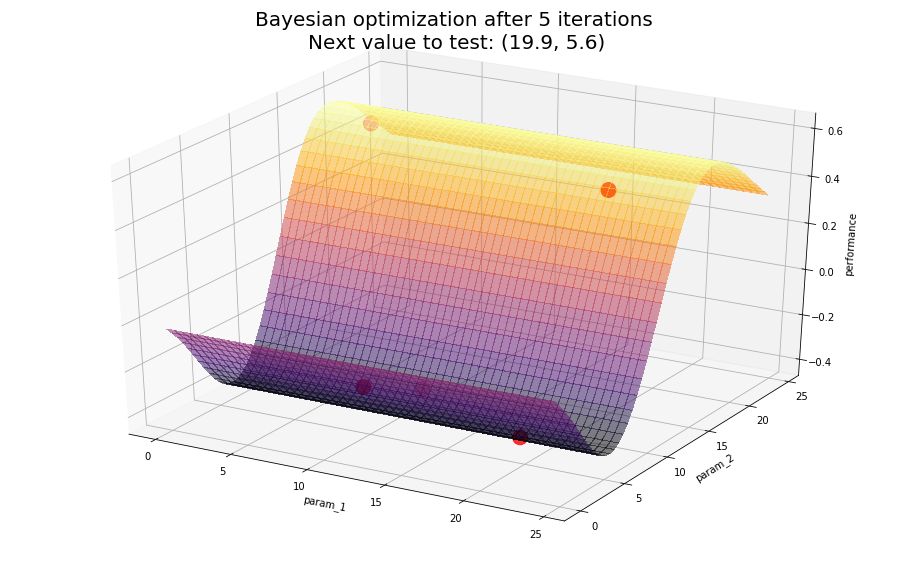

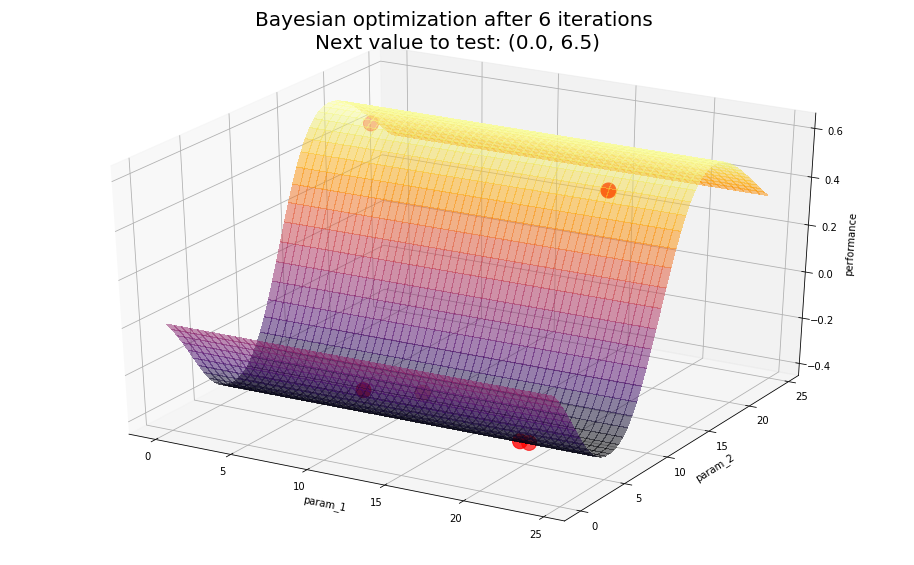

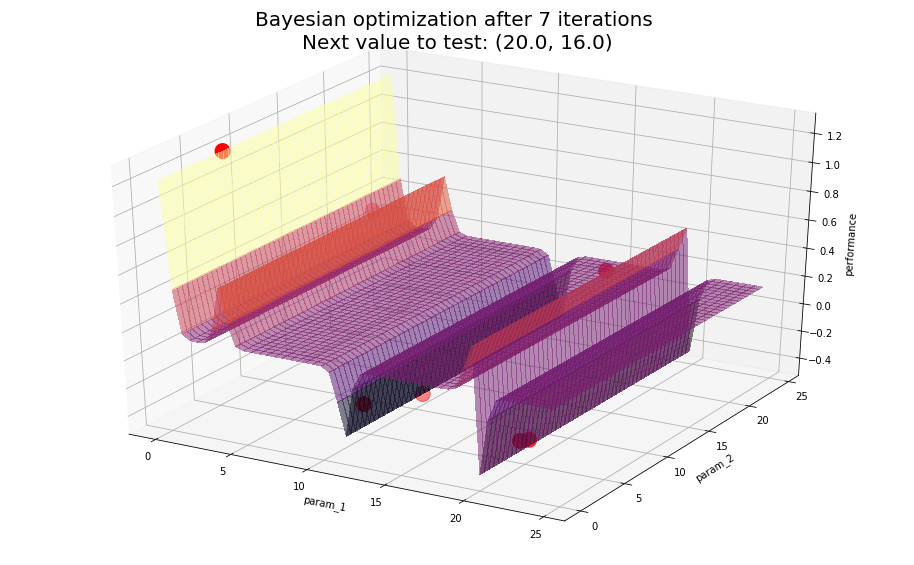

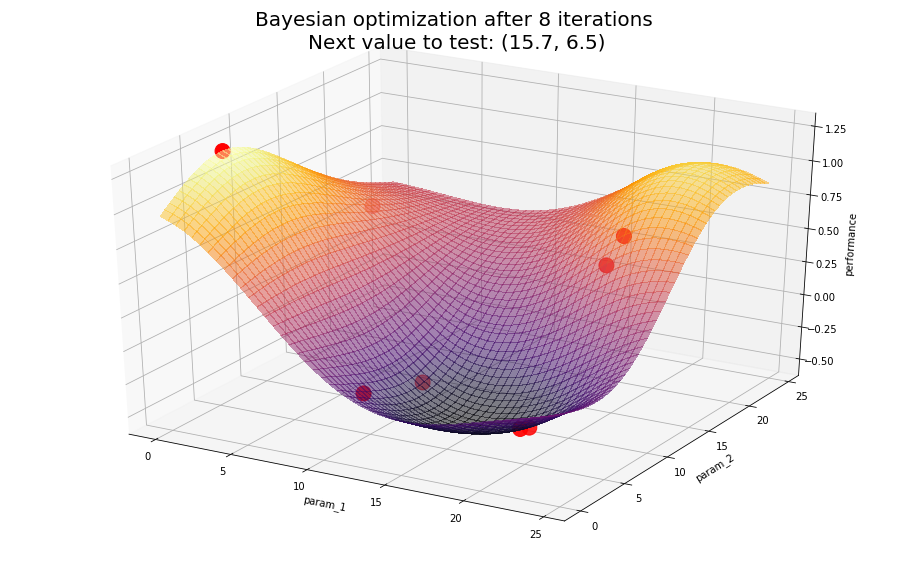

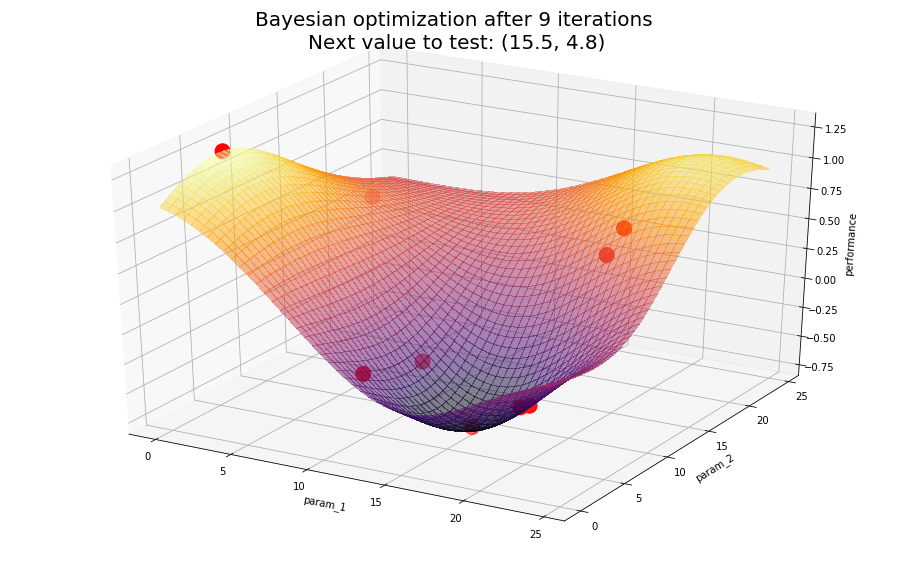

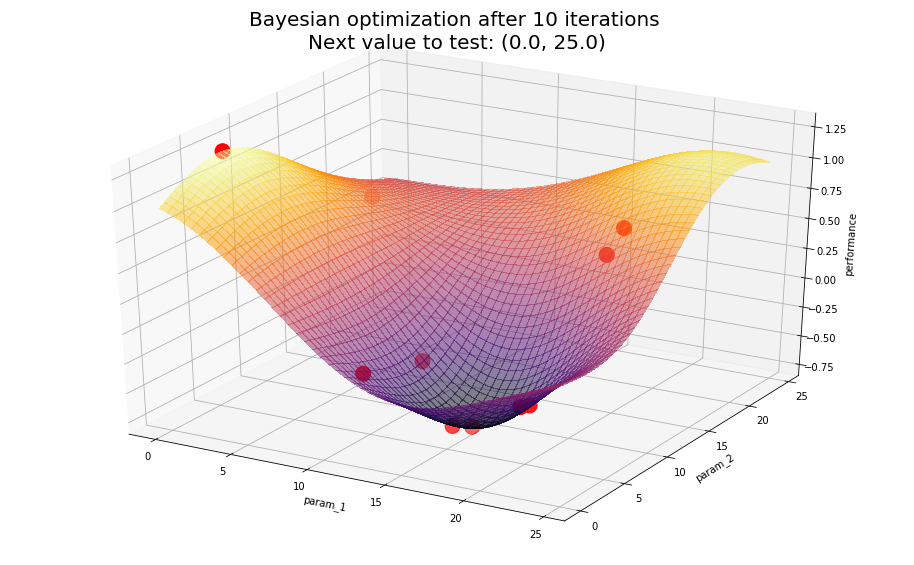

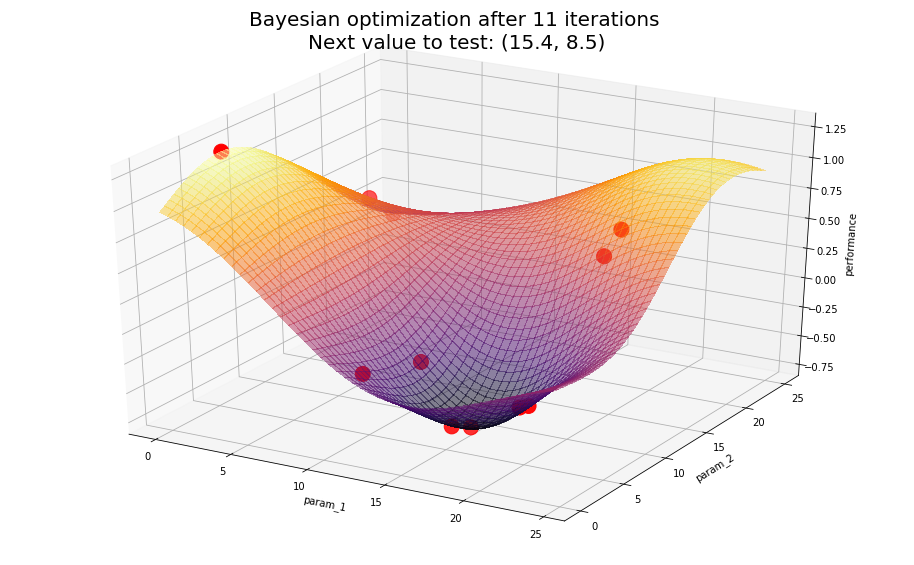

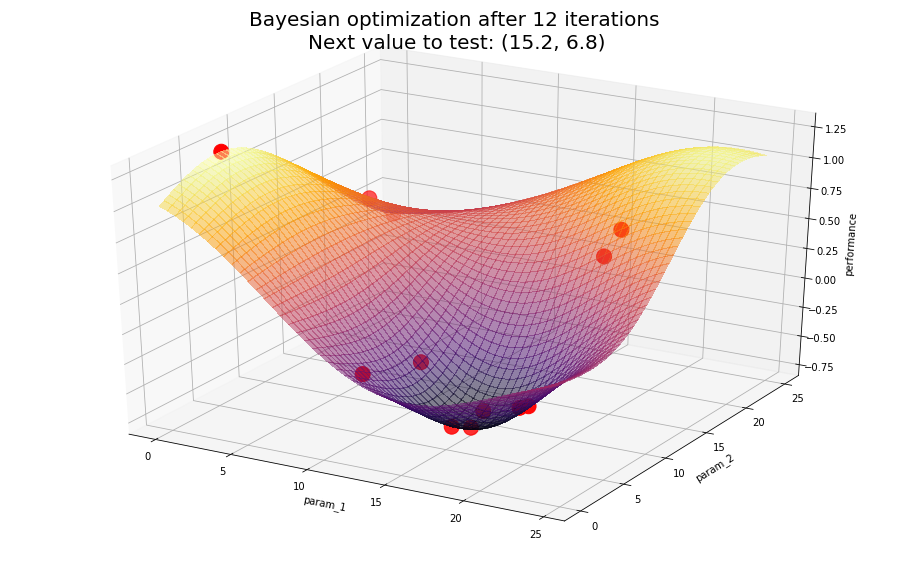

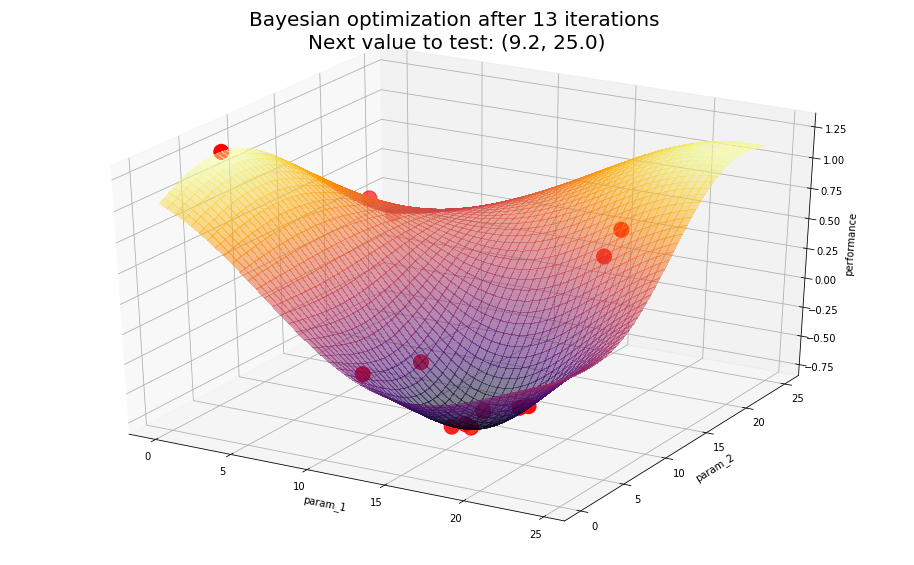

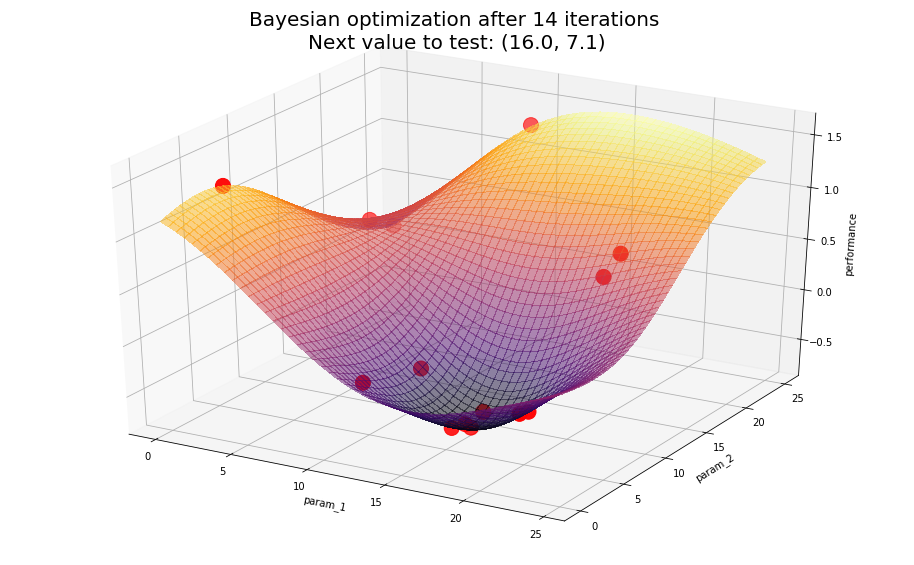

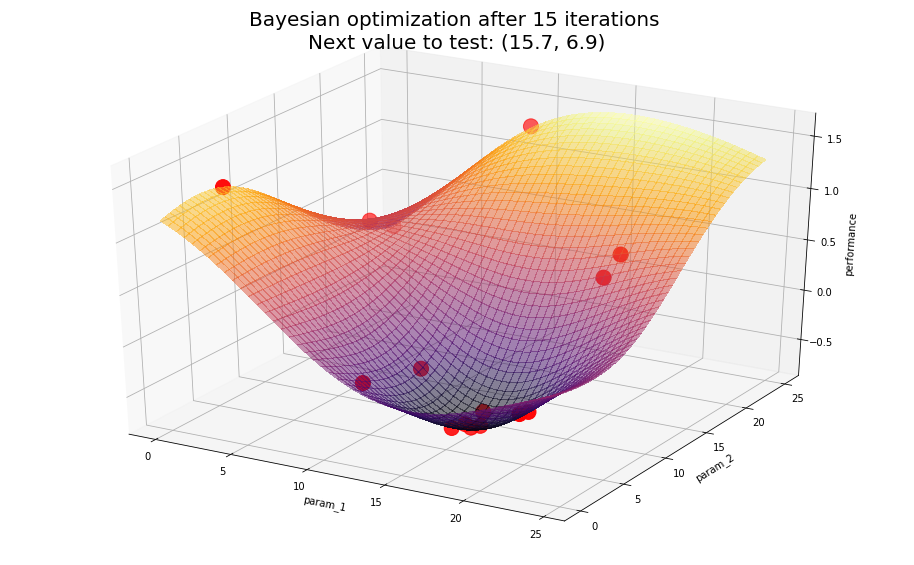

In [9]:
for iteration in range(5, 16):
    next_x = opt.ask()
    plot_optimizer(opt, iteration, np.round(next_x, 1))
    
    # Again, this would translate in a benchmark to get the true value
    f_val = true_function(next_x)
    print('{} - Set of parameters tested: {{param_1: {}, param_2: {}}} - '
          'Performance: {}s'.format(iteration,
                                    round(next_x[0], 3),
                                    round(next_x[1], 3),
                                    round(f_val, 3)))
    
    opt.tell(next_x, f_val)